## Importing libraries and preprocessing data

In [5]:
from google.colab import drive
import warnings

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F  # Functional
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

import torchvision

from tqdm import tqdm, tqdm_notebook
import itertools
import pickle
import os
import datetime
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Установим размер классифицируемых изображений
PIC_SIZE = 50
# Путь к предобработанным данным
pretrain_data_path = '/content/gdrive/My Drive/seminar_sln/data/preprocessed'
# Путь, куда сохраним модель
model_save_path =  '/content/gdrive/My Drive/DLSchool/Completed'

drive.mount('/content/gdrive/')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

Device: cuda:0
Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


Splitting the data into train and test

In [0]:
#!unzip -q /content/gdrive/My\ Drive/data.zip -d data
train_data_path = 'data/data'
test_data_path = 'data/data'

In [0]:
# Формирование наборов файлов
test_csv = pd.read_csv('test.csv')
test_files = test_csv['file_name'].tolist()
test_len = len(test_files)

pretrain_csv = pd.read_csv(pretrain_data_path + '/labels.csv')
pretrain_val_files = pretrain_csv['file_name'].tolist()
pretrain_val_labels = pretrain_csv['label'].tolist()

pretrain_files, preval_files = train_test_split(pretrain_val_files, \
                                                test_size=test_len, \
                                                stratify=pretrain_val_labels)

train_csv = pd.read_csv('train.csv')
train_val_files = train_csv['file_name'].tolist()
train_val_labels = train_csv['label'].tolist()

train_files, val_files = train_test_split(train_val_files, \
                                          test_size=test_len, \
                                          stratify=train_val_labels)

In [0]:
class SignsDataset(Dataset):

    def __init__(self, root_dir, files, labels_df=None):
        super().__init__()
        self.root_dir = root_dir
        self.files = files
        self.transform = torchvision.transforms.ToTensor()
        
        if labels_df is None:
            self.labels = None
        else:
            self.labels = []
            self.label_encoder = LabelEncoder()
            for f in files:
                l = labels_df.loc[labels_df['file_name'] == f]['label'].iloc[0]
                self.labels.append(l)
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return len(self.files)
      
    def load_sample(self, file):
        image = Image.open(file)
        #image = image.convert('RGB')
        image.load()
        return image 
      
    def _prepare_sample(self, image):
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        return np.array(image)      

    def __getitem__(self, idx):
        # Загрузим изображение и приведём к размеру 50х50
        img_name = self.root_dir + '/' + self.files[idx]
        
        x = self.load_sample(img_name)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = self.transform(x)
            
        if self.labels is None:
            return x
        else:
            label = self.labels[idx]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [0]:
pretrain_dataset = SignsDataset(pretrain_data_path, pretrain_files, labels_df=pretrain_csv)
preval_dataset = SignsDataset(pretrain_data_path, preval_files, labels_df=pretrain_csv)

train_dataset = SignsDataset(train_data_path, train_files, labels_df=train_csv)
val_dataset = SignsDataset(train_data_path, val_files, labels_df=train_csv)

test_dataset = SignsDataset(test_data_path, test_files)

pretrain_classes_num = len(np.unique(pretrain_dataset.labels))
train_classes_num = len(np.unique(train_dataset.labels))

# print('Lengths:', len(pretrain_dataset), len(preval_dataset), len(train_dataset), len(val_dataset), test_len)
# print('pretrain : {} classes'.format(pretrain_classes_num))
# print(np.unique(pretrain_val_labels))
# print('train : {} classes'.format(train_classes_num))
# print(np.unique(train_val_labels))

# проверка - что у нас выходит
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
# img, lbl = next(iter(train_loader))
# img = np.transpose(img, (0, 2, 3, 1))
# print(type(img))
# print(img.size())
# plt.imshow(img[0])
# lbl

## Create and train neural network

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for i, batch in enumerate(tqdm_notebook(train_loader)):
        inputs, labels = batch
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc  
  
def train(model, train_files, val_files, \
          opt, criterion, lr_shed, \
          epochs=20, batch_size=64, learning_rate=0.001):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    best_model_weights = model.state_dict()
    best_loss = 1000

    for epoch in tqdm_notebook(range(epochs)):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        lr_sched.step()
            
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc.item()))

        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = model.state_dict()
#         if train_acc >= 0.999:
#             print('break: reaching maximum accuracy')
#             break
    
    model.load_state_dict(best_model_weights)
    return model, history 
  
def just_train(model, train_files, \
               opt, criterion, lr_shed, \
               epochs=20, batch_size=64, learning_rate=0.001):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)

    for epoch in tqdm_notebook(range(epochs)):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        lr_sched.step()
            
    return model  
  
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for i, inputs in enumerate(tqdm_notebook(test_loader)):
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs  
  
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs  

## Let's use pretrained ResNet34 model:

In [55]:
my_cnn = torchvision.models.resnet34(pretrained=True)
my_cnn_str = 'resnet34'
print(str(my_cnn))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Adjusting parameters of our model

In [56]:
NUM_EPOCHS =12
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
SCHED_STEP_SIZE = 4
SCHED_GAMMA = 0.7

torch.manual_seed(0)
my_cnn.fc = nn.Linear(512, pretrain_classes_num)
my_cnn = my_cnn.to(DEVICE)


opt = torch.optim.Adam(my_cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
lr_sched = lr_scheduler.StepLR(opt, step_size=SCHED_STEP_SIZE, gamma=SCHED_GAMMA)

start_time = datetime.datetime.now()

print('PRETRAIN on GERMAN SIGNS:')
my_cnn, _ = train(my_cnn, pretrain_dataset, preval_dataset, \
                  opt, criterion, lr_sched, \
                  epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
#loss, acc, val_loss, val_acc = zip(*history)

print('Extra TRAIN on VAL data:')
lr_sched = lr_scheduler.StepLR(opt, step_size=SCHED_STEP_SIZE, gamma=SCHED_GAMMA)
my_cnn = just_train(my_cnn, preval_dataset, \
                  opt, criterion, lr_sched, \
                  epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

print('TRAIN on SWEDEN SIGNS:')
torch.manual_seed(0)
my_cnn = my_cnn.to('cpu')
my_cnn.fc = nn.Sequential(
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, train_classes_num),
)
my_cnn = my_cnn.to(DEVICE)

opt = torch.optim.Adam(my_cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
lr_sched = lr_scheduler.StepLR(opt, step_size=SCHED_STEP_SIZE, gamma=SCHED_GAMMA)

my_cnn, _ = train(my_cnn, train_dataset, val_dataset, \
                  opt, criterion, lr_sched, \
                  epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
#loss2, acc2, val_loss2, val_acc2 = zip(*history)

print('Extra TRAIN on VAL data:')
lr_sched = lr_scheduler.StepLR(opt, step_size=SCHED_STEP_SIZE, gamma=SCHED_GAMMA)
my_cnn = just_train(my_cnn, val_dataset, \
                  opt, criterion, lr_sched, \
                  epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

PRETRAIN on GERMAN SIGNS:



Epoch 001 train_loss: 1.0198     val_loss 0.4319 train_acc 0.7125 val_acc 0.8902



Epoch 002 train_loss: 0.3664     val_loss 0.3409 train_acc 0.8948 val_acc 0.9131



Epoch 003 train_loss: 0.1844     val_loss 0.2458 train_acc 0.9412 val_acc 0.9262



Epoch 004 train_loss: 0.1361     val_loss 0.2599 train_acc 0.9575 val_acc 0.9361



Epoch 005 train_loss: 0.0626     val_loss 0.1533 train_acc 0.9825 val_acc 0.9557



Epoch 006 train_loss: 0.0262     val_loss 0.1784 train_acc 0.9913 val_acc 0.9639



Epoch 007 train_loss: 0.0785     val_loss 0.1369 train_acc 0.9786 val_acc 0.9607



Epoch 008 train_loss: 0.0194     val_loss 0.1375 train_acc 0.9940 val_acc 0.9705



Epoch 009 train_loss: 0.0096     val_loss 0.1232 train_acc 0.9972 val_acc 0.9738



Epoch 010 train_loss: 0.0035     val_loss 0.1320 train_acc 0.9992 val_acc 0.9770



Epoch 011 train_loss: 0.0004     val_loss 0.1402 train_acc 1.0000 val_acc 0.9754



Epoch 012 train_loss: 0.0001     val_loss 0.1382 train_acc 1.0000 val_acc 0.9754
Extra TRAIN on VAL data:


TRAIN on SWEDEN SIGNS:



Epoch 001 train_loss: 0.5107     val_loss 0.2936 train_acc 0.8674 val_acc 0.9426



Epoch 002 train_loss: 0.1291     val_loss 0.1439 train_acc 0.9651 val_acc 0.9623



Epoch 003 train_loss: 0.0566     val_loss 0.0927 train_acc 0.9831 val_acc 0.9738



Epoch 004 train_loss: 0.0853     val_loss 0.0422 train_acc 0.9815 val_acc 0.9934



Epoch 005 train_loss: 0.0204     val_loss 0.0816 train_acc 0.9952 val_acc 0.9770



Epoch 006 train_loss: 0.0102     val_loss 0.0336 train_acc 0.9968 val_acc 0.9918



Epoch 007 train_loss: 0.0248     val_loss 0.0763 train_acc 0.9942 val_acc 0.9869



Epoch 008 train_loss: 0.0671     val_loss 0.0701 train_acc 0.9820 val_acc 0.9852



Epoch 009 train_loss: 0.0134     val_loss 0.0849 train_acc 0.9974 val_acc 0.9836



Epoch 010 train_loss: 0.0043     val_loss 0.0462 train_acc 0.9995 val_acc 0.9902



Epoch 011 train_loss: 0.0004     val_loss 0.0358 train_acc 1.0000 val_acc 0.9918



Epoch 012 train_loss: 0.0001     val_loss 0.0361 train_acc 1.0000 val_acc 0.9918
Extra TRAIN on VAL data:


### Drawing training curves

### Showing confusion matrix

In [0]:
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()

Normalized confusion matrix


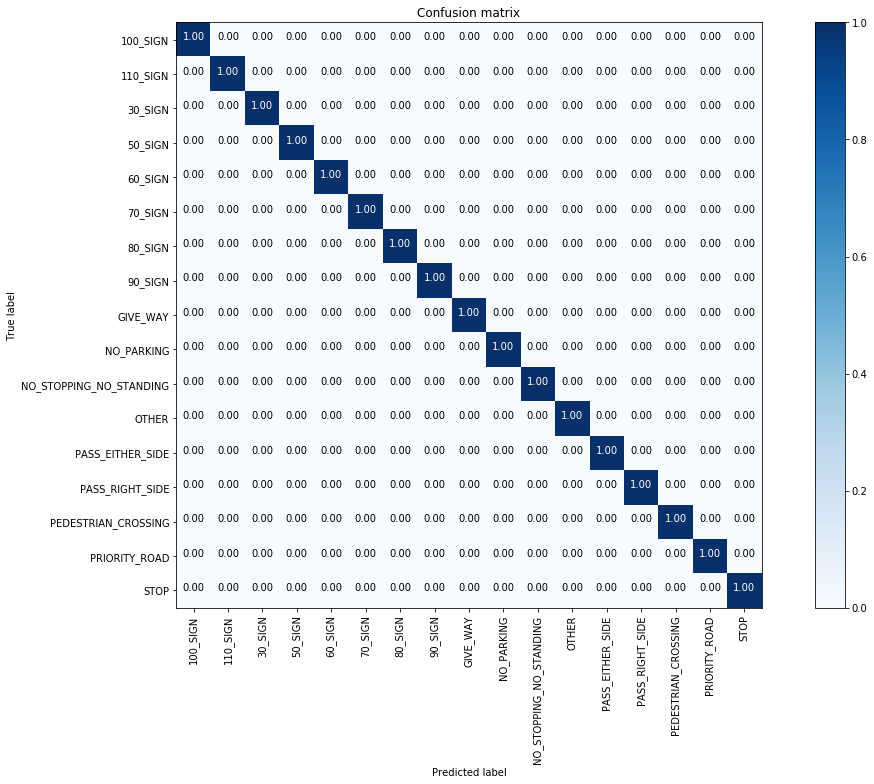

In [58]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        predictions = my_cnn(x.to(DEVICE))
        _, predictions = torch.max(predictions.cpu(), 1)
        
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

#feature_names = train_loader.dataset.labels

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(train_classes_num))
# Выведем её
plot_confusion_matrix(cm, np.unique(train_dataset.labels), normalize=True)

### Showing accuracy of each class:

In [59]:
class_correct = [0 for i in range(train_classes_num)]
class_total = [0 for i in range(train_classes_num)]

c = (predictions_all == y_test_all).squeeze()
for i in range(len(predictions_all)):
    label = predictions_all[i]            
    class_correct[label] += c[i].item()
    class_total[label] += 1

print(class_total, 'sum:', sum(class_total))

for i in range(train_classes_num):
    print('Accuracy of %5s : %2d %%' % (
        (train_dataset.labels[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

[15, 4, 7, 29, 5, 37, 15, 4, 35, 11, 12, 78, 5, 89, 153, 107, 4] sum: 610
Accuracy of PEDESTRIAN_CROSSING : 100 %
Accuracy of PRIORITY_ROAD : 100 %
Accuracy of 50_SIGN : 100 %
Accuracy of 80_SIGN : 100 %
Accuracy of NO_STOPPING_NO_STANDING : 100 %
Accuracy of PASS_RIGHT_SIDE : 100 %
Accuracy of PRIORITY_ROAD : 100 %
Accuracy of OTHER : 100 %
Accuracy of PEDESTRIAN_CROSSING : 100 %
Accuracy of 60_SIGN : 100 %
Accuracy of PEDESTRIAN_CROSSING : 100 %
Accuracy of PASS_RIGHT_SIDE : 100 %
Accuracy of OTHER : 100 %
Accuracy of PRIORITY_ROAD : 100 %
Accuracy of PRIORITY_ROAD : 100 %
Accuracy of GIVE_WAY : 100 %
Accuracy of PRIORITY_ROAD : 100 %


## Let's estimate quality on separate frames from validation

190
PRIORITY_ROAD
15
PRIORITY_ROAD


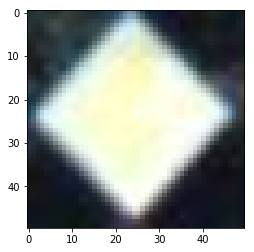

In [60]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)   

random_characters = int(np.random.uniform(0, len(val_dataset)))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_cnn, ex_img.unsqueeze(0))
img_label = val_dataset.label_encoder.inverse_transform([true_label])[0]

print(random_characters)
print(img_label)
max_prob = np.argmax(probs_im)
pred_label = val_dataset.label_encoder.inverse_transform([max_prob])[0]
print(max_prob)
print(pred_label)
imshow(ex_img.data.cpu())

## Generating a test file to submit

In [61]:
test_loader = DataLoader(test_dataset, batch_size=1)
answer = []

#for img in test_loader:
for img in tqdm_notebook(test_loader):  
    probs = predict_one_sample(my_cnn, img)
    max_prob = np.argmax(probs)
    img_label = train_dataset.label_encoder.inverse_transform([max_prob])[0]  
    answer.append(img_label)   

prediction_df = test_csv
    
prediction_df['label'] = pd.Series(answer)
prediction_df.to_csv('my_submission.csv', index=False)

from google.colab import files
files.download('my_submission.csv')